# Duomenu aibes aprasymas, transformacijos

#### Importuojame paketus, paruošiame grafikų stilių

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt
import contextily as cx

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

## Importuojam duomenis

In [40]:
df = pd.read_csv(
    'aisdk-2026-02-05.csv',
    engine='pyarrow'
)

In [41]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 15750590 entries, 0 to 15750589
Data columns (total 26 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   # Timestamp                     str    
 1   Type of mobile                  str    
 2   MMSI                            int64  
 3   Latitude                        float64
 4   Longitude                       float64
 5   Navigational status             str    
 6   ROT                             float64
 7   SOG                             float64
 8   COG                             float64
 9   Heading                         float64
 10  IMO                             str    
 11  Callsign                        str    
 12  Name                            str    
 13  Ship type                       str    
 14  Cargo type                      str    
 15  Width                           float64
 16  Length                          float64
 17  Type of position fixing device  str 

## Filtruojam geografinį regioną, navigacinį statusą, `Type of mobile`

In [42]:
df_filtered = df[
    df['Latitude'].between(54, 56) &
    df['Longitude'].between(12, 17) &
    (df['Navigational status'] == 'Under way using engine') &
    (df['Type of mobile'] == 'Class A')
].copy(deep=True)

del df

#### Vizualizuojam geografinį regioną

## Ištiriam nelogiškas ar nereikalingas reikšmes

In [43]:
df_filtered['Ship type'].value_counts()

Ship type
Cargo              684262
Passenger          263383
Tanker             246091
Pilot              110811
SAR                 92871
Fishing             59486
Other               45911
Dredging            41171
HSC                 40135
Undefined           38660
Tug                 38111
Towing              12116
Spare 1             11088
Law enforcement      8943
Military              153
Name: count, dtype: int64

> `Undefined` nereikia: mums reikia tik laivų, kuriu tipas yra žinomas, kad juos galėtume klasifikuoti, klasterizuoti ir t.t.

In [44]:
df_filtered = df_filtered[ ~(df_filtered['Ship type'] == 'Undefined') ]

In [45]:
numerical = ['ROT', 'SOG', 'COG', 'Heading']
df_filtered[numerical].max()

ROT       697.500
SOG       102.200
COG       359.900
Heading   359.000
dtype: float64

In [46]:
df_filtered[numerical].min()

ROT       -231.400
SOG          0.000
COG          0.000
Heading      0.000
dtype: float64

<Axes: xlabel='SOG', ylabel='Ship type'>

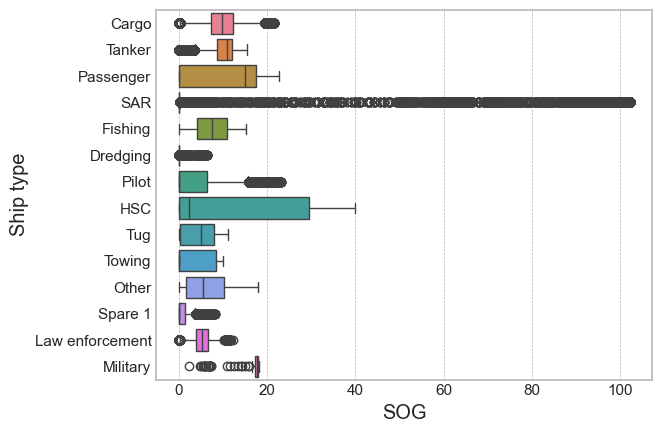

In [47]:
sns.boxplot(y='Ship type', x='SOG', hue='Ship type', data=df_filtered)

> Išskirtinai didelis SOG (100 mazgų ~ 185 kmh) yra paieškos ir gelbėjimo (*angl. Save and rescue, SAR*) laivo, kas, kontekste, nėra nelogiškas greitis

### Ištiriam praleistas reikšmes, skirtumus tarp stebėjimų

Čia mūsų siekis bus dvejopas:
1. Susitvarkyti su praleistomis reikšmėmis;
2. Išplėsti laiko eilutes į lygiai vienos minutės intervalus, t. y, padaryti taip, kad tarp vieno laivo AIS signalų visą laiką būtų vienos minutės skirtumas.

In [48]:
df_filtered[numerical].isnull().sum()

ROT        380882
SOG          2111
COG         46301
Heading    130393
dtype: int64

### Heading praleistos reikšmės

In [49]:
output = []

for ship_type, type_data in df_filtered.groupby('Ship type'):

    for col in numerical:
        output.append({
            'Laivo tipas': ship_type,
            'Kintamasis': col,
            'Praleistų reikšmių dalis, %': type_data[col].isnull().mean() * 100
        })

pd.DataFrame(output).pivot(columns=['Kintamasis'], index=['Laivo tipas'])

Praleistų reikšmių dalis, %                     
Kintamasis                              COG Heading    ROT   SOG
Laivo tipas                                                     
Cargo                                 0.013   3.129 17.574 0.012
Dredging                             15.904   0.000  2.992 0.000
Fishing                               0.000   0.000 29.578 0.000
HSC                                   0.000   0.000 18.146 0.000
Law enforcement                       0.000   8.185 20.183 0.000
Military                              0.000   0.000  0.000 0.000
Other                                 0.331   0.163 38.546 0.015
Passenger                             0.749  11.197 16.498 0.749
Pilot                                 0.005  10.355 49.013 0.005
SAR                                  40.409  72.360 73.208 0.039
Spare 1                               0.000   0.000 23.909 0.000
Tanker                                0.002   0.004  9.891 0.002
Towing                                0.000   0.000 18.752 0.000
Tug                                   0.003   0.000 52.470 0.003

> Kadangi SAR tipo laivai turi virš 50 % praleistų reikšmių `Heading` ir `ROT` kintamuosiuose, šitą laivo tipą išimsime. Taip pat išimsime Tug laivo tipą, kadangi jo `ROT` požymis turi virš 50 % praleistų reikšmių

In [50]:
df_filtered = df_filtered[
    ~( (df_filtered['Ship type'] == 'SAR') | 
       (df_filtered['Ship type'] == 'Tug') )
]

#### Praleistų reikšmių skaičius/dalis kiekvienam kintamajam

In [51]:
df_filtered[numerical].isnull().agg(['sum', 'mean'])

,ROT,SOG,COG,Heading
sum,292896.000,2074.000,8772.000,63192.000
mean,0.192,0.001,0.006,0.041


> Toliau patikrinsime ar yra laivų, kurių kuriame nors AIS signalų rinkinyje yra 100 % praleistų reikšmių

In [52]:
for mmsi, mmsi_data in df_filtered.groupby('MMSI'):

    if any( df_filtered[numerical].isnull().mean() >= 1 ):
        print(mmsi)

> Toliau reikia ištirti ar laiko skirtumas tarp stebėjimų neviršija 2 valandų (literatūroje taikyta riba)

In [53]:
from datetime import timedelta

In [54]:
df_filtered['# Timestamp'] = pd.to_datetime( df_filtered['# Timestamp'] )

In [55]:
rm_mmsi = []
for mmsi, mmsi_data in df_filtered.groupby('MMSI'):

    mmsi_data = mmsi_data.sort_values('# Timestamp')

    time_diff = mmsi_data['# Timestamp'].diff(1)
    max_time_diff = time_diff.max()

    if max_time_diff >= timedelta(hours=2):
        rm_mmsi.append(mmsi)

print(f'Pašalinsime {len(rm_mmsi)} laivų')

Pašalinsime 33 laivų


In [56]:
is_mmsi_removed = df_filtered['MMSI'].isin( set(rm_mmsi) )
df_filtered = df_filtered[ ~is_mmsi_removed ]

## isskirtys

# isimt ROT = 0 ir su boxplotu patikrint isskirtis

In [57]:

numerical_cols = ["ROT", "SOG", "COG", "Heading"]
for col in numerical_cols:
    df_col = df_filtered[col]
    
    Q1 = df_col.quantile(0.25)
    Q3 = df_col.quantile(0.75)
    IQR = Q3 - Q1
    
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outliers = df_filtered[(df_filtered[col] < lower) | (df_filtered[col] > upper)]
    
    print(f"\n{col}")
    print("Lower:", round(lower, 2))
    print("Upper:", round(upper, 2))
    print("Min:", round(df_col.min(), 2))
    print("Max:", round(df_col.max(), 2))
    print("Outliers:", len(outliers))



ROT
Lower: 0.0
Upper: 0.0
Min: -116.1
Max: 237.9
Outliers: 249968

SOG
Lower: -7.05
Upper: 22.95
Min: 0.0
Max: 27.1
Outliers: 230

COG
Lower: -193.75
Upper: 510.65
Min: 0.0
Max: 359.9
Outliers: 0

Heading
Lower: -188.5
Upper: 511.5
Min: 0.0
Max: 359.0
Outliers: 0


Taikant IQR metodą nustatyta, kad kintamasis ROT turi labai daug išskirčių. Tačiau tai paaiškinama tuo, kad didžioji dalis stebėjimų turi reikšmę 0 (laivas juda tiesiai), todėl kvartilių intervalas lygus nuliui ir visi nenuliniai stebėjimai klasifikuojami kaip išskirtys. Todėl pasirinkome išskirčių nešalinti.


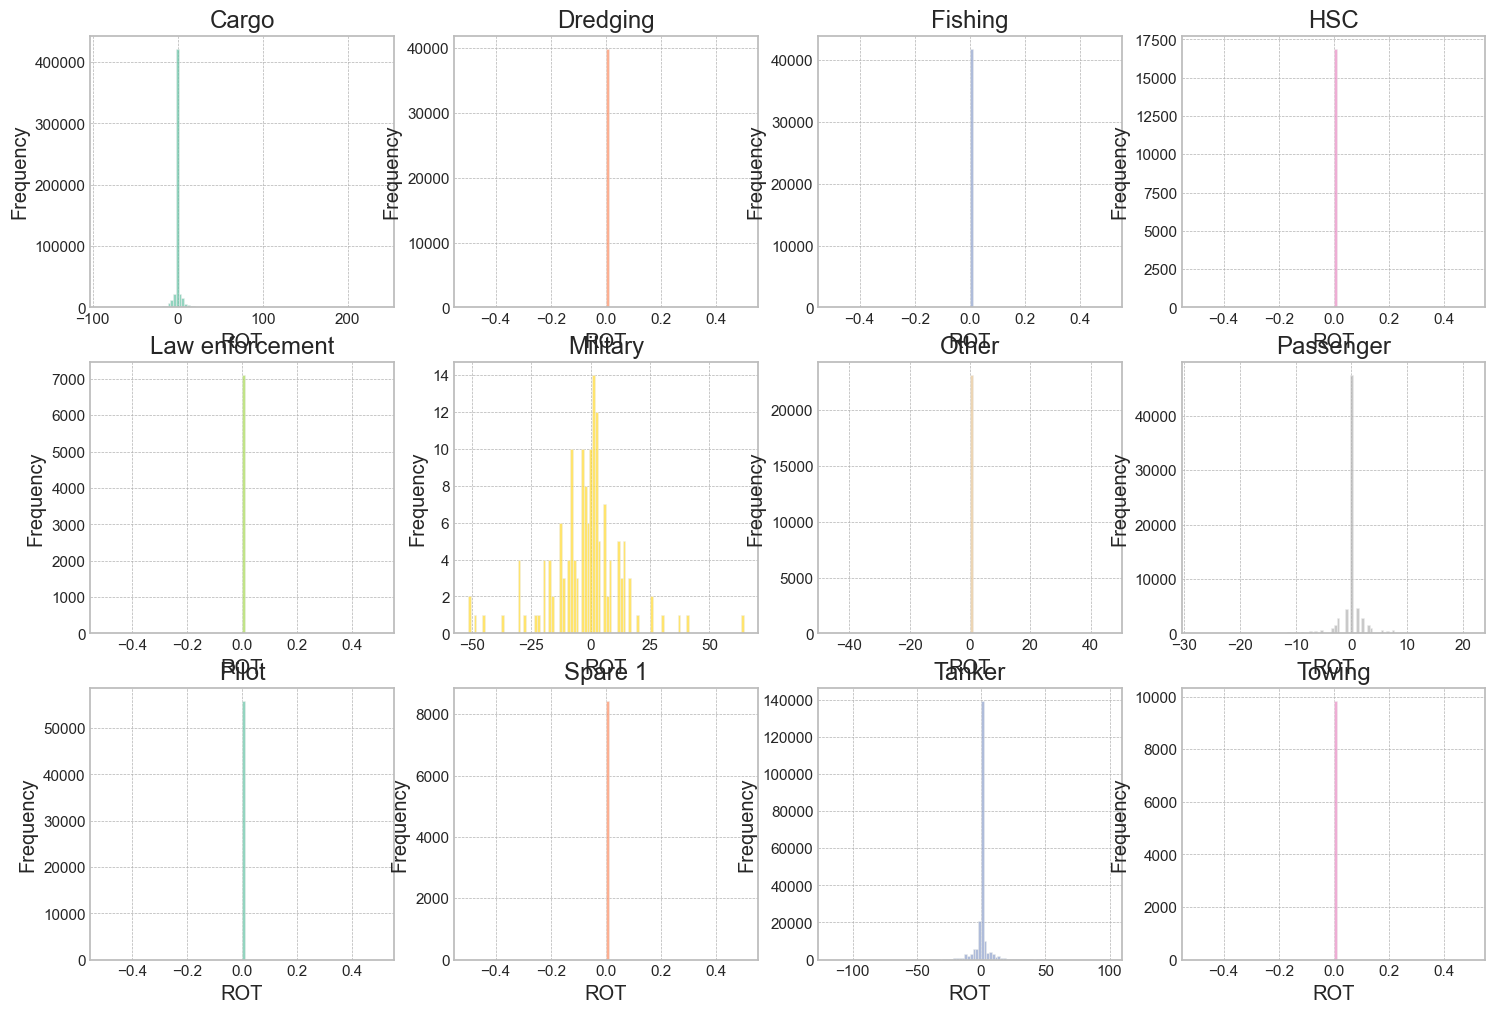

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

ship_groups = [
    (ship_type, df_type)
    for ship_type, df_type in df_filtered.groupby("Ship type")
    #if len(df_type) >= 1000
]

n = len(ship_groups)

cols = 4
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * rows))
axes = axes.flatten()

palette = sns.color_palette("Set2", n)

for i, ((ship_type, df_type), color) in enumerate(zip(ship_groups, palette)):
    axes[i].hist(
        df_type["ROT"],
        bins=100,
        color=color,
        alpha=0.7
    )
    axes[i].set_title(ship_type)
    axes[i].set_xlabel("ROT")
    axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


<Figure size 640x480 with 0 Axes>

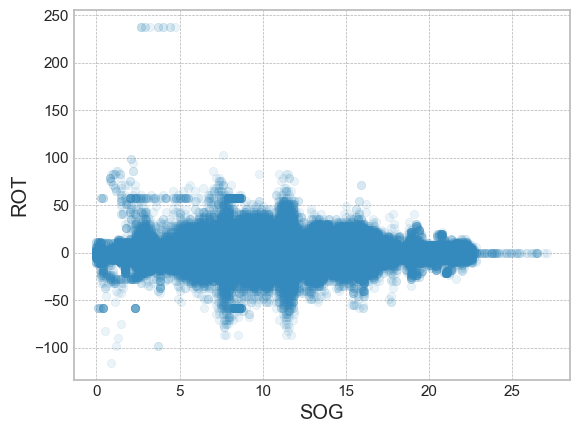

In [59]:

plt.suptitle("ROT Distribution by Ship Type", fontsize=16)
plt.tight_layout()
plt.show()
plt.scatter(df_filtered["SOG"], df_filtered["ROT"], alpha=0.1)
plt.xlabel("SOG")
plt.ylabel("ROT")
plt.show()

### Praleistų reikšmių užpildymas: kubinė interpoliacija

In [60]:
dfs = []
for mmsi, mmsi_df in df_filtered.groupby('MMSI'):
    
    # Atliekam transformacijq
    mmsi_df['Heading'] = mmsi_df['Heading']\
        .apply(lambda x: 360 - x if x > 180.0 else x)
    mmsi_df['COG'] = mmsi_df['COG']\
        .apply(lambda x: 360 - x if x > 180.0 else x)

    # Išplėčiame ir interpoliuojame
    output_df = mmsi_df.set_index('# Timestamp')\
        [['Latitude', 'Longitude', 'ROT', 'SOG', 'COG', 'Heading']]\
        .resample('60s')\
        .median()\
        .interpolate('pchip')\
        .reset_index()

    # Ištaisome klaidas
    output_df['Heading'] = np.clip(output_df['Heading'], 0, 360)
    output_df['COG'] = np.clip(output_df['COG'], 0, 360)
    output_df['Latitude'] = np.clip(output_df['Latitude'], 54.0, 56.0)
    output_df['Longitude'] = np.clip(output_df['Longitude'], 12.0, 17.0)

    # Apskaičiuojame komponentes
    output_df['dist_x'] = output_df['Latitude'].diff(1).abs()
    output_df['dist_y'] = output_df['Longitude'].diff(1).abs()

    # Priskiriame MMSI ir laivo tipo reikšmes, nes šiuo metu jų nėra output_df
    output_df['MMSI'] = mmsi
    output_df['Ship type'] = mmsi_df['Ship type'].values[0]

    # Surenkame
    dfs.append(output_df)

df_interpolated = pd.concat(dfs, ignore_index=True).dropna()

In [61]:
df_interpolated.head()

,# Timestamp,Latitude,Longitude,ROT,SOG,COG,Heading,dist_x,dist_y,MMSI,Ship type
1,2026-05-02 17:01:00,55.676,15.926,0.000,11.800,94.600,95.000,0.000,0.006,209221000,Tanker
2,2026-05-02 17:02:00,55.675,15.920,0.000,11.700,96.000,96.000,0.000,0.006,209221000,Tanker
3,2026-05-02 17:03:00,55.675,15.915,0.000,11.850,91.850,93.500,0.000,0.005,209221000,Tanker
4,2026-05-02 17:04:00,55.675,15.911,0.000,11.900,92.350,96.000,0.000,0.004,209221000,Tanker
5,2026-05-02 17:05:00,55.675,15.904,0.000,11.900,96.150,95.500,0.000,0.007,209221000,Tanker


# main

### Rinkinio peržiūra

In [62]:
data = df_interpolated

In [63]:
data = data.sort_values(['MMSI', '# Timestamp'])

In [64]:
data.info()

<class 'pandas.DataFrame'>
Index: 151384 entries, 1 to 163985
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   # Timestamp  151384 non-null  datetime64[us]
 1   Latitude     151384 non-null  float64       
 2   Longitude    151384 non-null  float64       
 3   ROT          151384 non-null  float64       
 4   SOG          151384 non-null  float64       
 5   COG          151384 non-null  float64       
 6   Heading      151384 non-null  float64       
 7   dist_x       151384 non-null  float64       
 8   dist_y       151384 non-null  float64       
 9   MMSI         151384 non-null  int64         
 10  Ship type    151384 non-null  str           
dtypes: datetime64[us](1), float64(8), int64(1), str(1)
memory usage: 14.7 MB


In [65]:
data.head()

,# Timestamp,Latitude,Longitude,ROT,SOG,COG,Heading,dist_x,dist_y,MMSI,Ship type
1,2026-05-02 17:01:00,55.676,15.926,0.000,11.800,94.600,95.000,0.000,0.006,209221000,Tanker
2,2026-05-02 17:02:00,55.675,15.920,0.000,11.700,96.000,96.000,0.000,0.006,209221000,Tanker
3,2026-05-02 17:03:00,55.675,15.915,0.000,11.850,91.850,93.500,0.000,0.005,209221000,Tanker
4,2026-05-02 17:04:00,55.675,15.911,0.000,11.900,92.350,96.000,0.000,0.004,209221000,Tanker
5,2026-05-02 17:05:00,55.675,15.904,0.000,11.900,96.150,95.500,0.000,0.007,209221000,Tanker


In [66]:
gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.Longitude, data.Latitude), crs="EPSG:4326"
)

##### Pavyzdinė tanklaivio judėjimo trajektorija

Text(0.5, 1.0, 'Laivas 538007403, 2026-02-05 00:05-13:04')

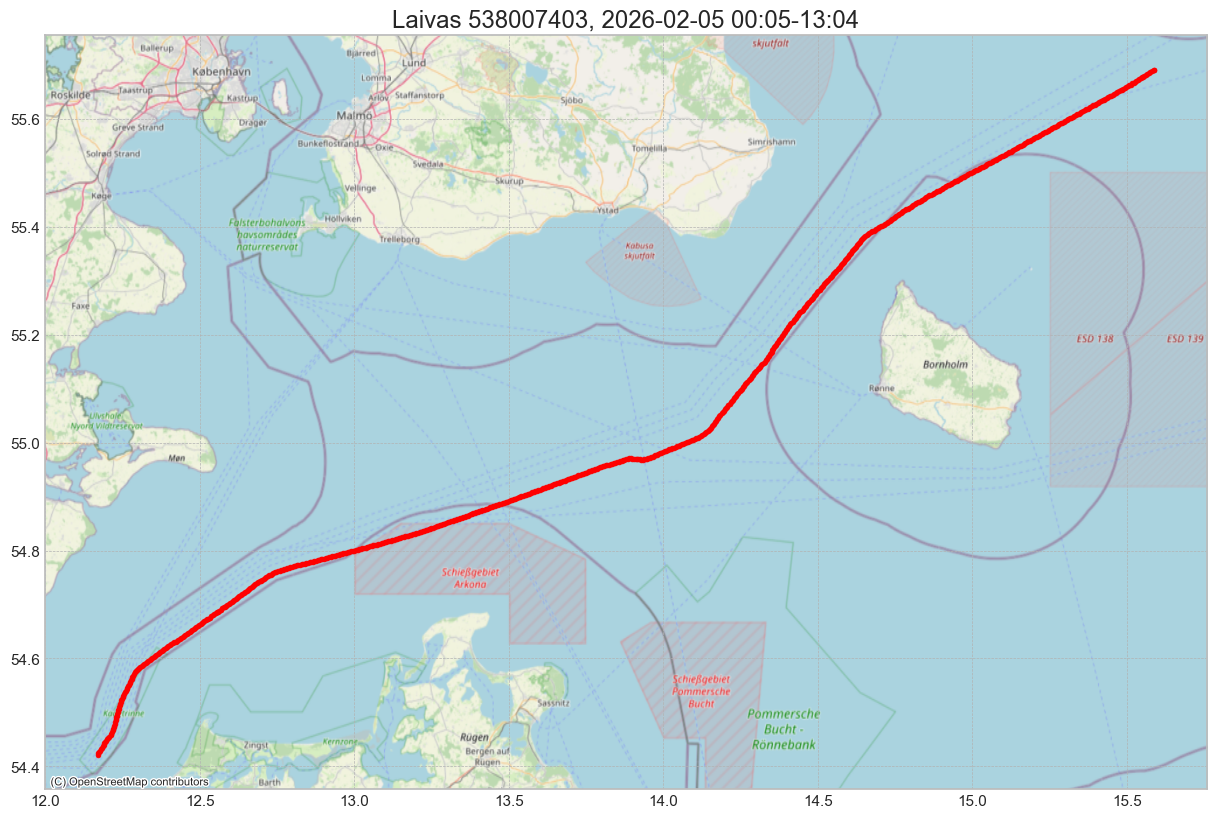

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

gdf[gdf.MMSI == 538007403].plot(ax=ax, markersize=12, color='red')

cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.OpenStreetMap.Mapnik, zoom=9)

plt.title('Laivas 538007403, 2026-02-05 00:05-13:04')

# plt.savefig('path1.png', format='png', dpi=300, bbox_inches="tight")

##### Pavyzdinė krovininio laivo judėjimo trajektorija

Text(0.5, 1.0, 'Laivas 636022047, 2026-02-05 06:22-18:04')

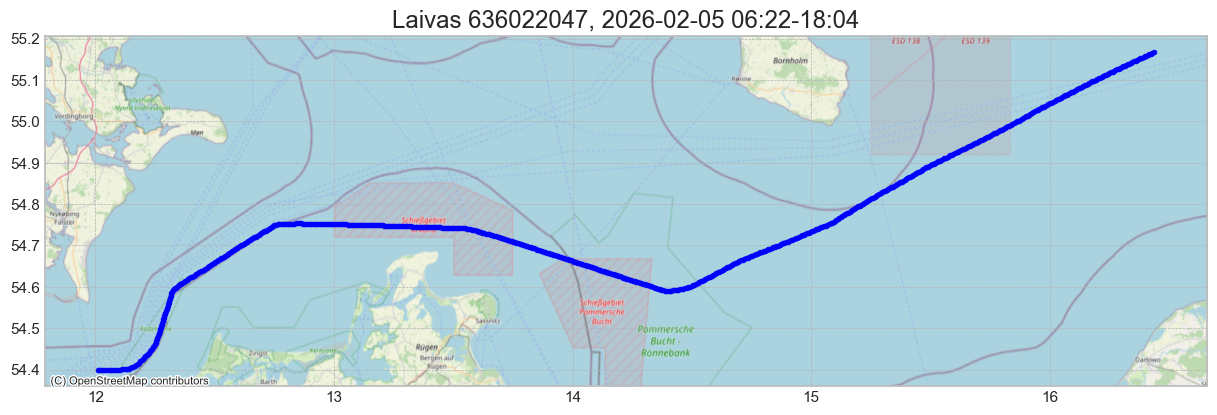

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

gdf[gdf.MMSI == 636022047].plot(ax=ax, markersize=12, color='blue')

cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.OpenStreetMap.Mapnik, zoom=9)

plt.title('Laivas 636022047, 2026-02-05 06:22-18:04')

# plt.savefig('path2.png', format='png', dpi=600, bbox_inches="tight")

In [69]:
numerical = ['ROT', 'SOG', 'COG', 'Heading', 'dist_x', 'dist_y']

In [70]:
corr = data[numerical]\
    .select_dtypes(include=['float64'])\
    .corr(method='spearman')

In [71]:
corr

,ROT,SOG,COG,Heading,dist_x,dist_y
ROT,1.000,-0.001,-0.013,-0.009,0.002,-0.001
SOG,-0.001,1.000,0.221,0.234,0.736,0.819
COG,-0.013,0.221,1.000,0.812,0.176,0.154
Heading,-0.009,0.234,0.812,1.000,0.177,0.164
dist_x,0.002,0.736,0.176,0.177,1.000,0.441
dist_y,-0.001,0.819,0.154,0.164,0.441,1.000


<Axes: >

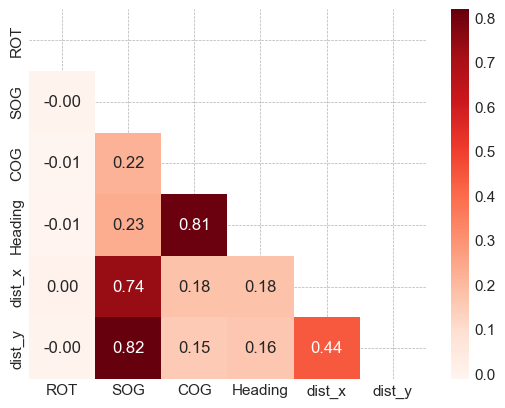

In [72]:
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr,
            mask=mask,
            cmap='Reds',
            xticklabels=True,
            yticklabels=True,
            annot=True,
            fmt=".2f")

# plt.savefig('corr_plot.png', format='png', dpi=300, bbox_inches="tight")

# paziureti koreliacijas pagal laivu tipus

# Aprasomoji statistika, tankiai, grafikai

## Aprasomoji statistika

In [73]:
numeric_cols = data[numerical]

desc_stats = pd.DataFrame({
    'min': numeric_cols.min(),
    'Q1': numeric_cols.quantile(0.25),
    'median': numeric_cols.median(),
    'mean': numeric_cols.mean(),
    'Q3': numeric_cols.quantile(0.75),
    'max': numeric_cols.max(),
    'variance': numeric_cols.var(),
    'std_dev': numeric_cols.std()
})

pd.options.display.float_format = '{:.3f}'.format
print(desc_stats)

            min     Q1  median   mean      Q3     max  variance  std_dev
ROT     -66.700  0.000   0.000  0.009   0.000  75.000     5.575    2.361
SOG       0.000  4.550   8.800  7.963  11.300  26.000    25.972    5.096
COG       0.000 59.600  89.650 88.540 117.900 180.000  1786.449   42.266
Heading   0.000 65.000  88.500 89.066 117.000 180.000  1616.797   40.209
dist_x    0.000  0.000   0.001  0.001   0.002   0.010     0.000    0.001
dist_y    0.000  0.001   0.003  0.003   0.005   0.024     0.000    0.002


## Tankio grafikai pagal laivo tipa

### pagal SOG

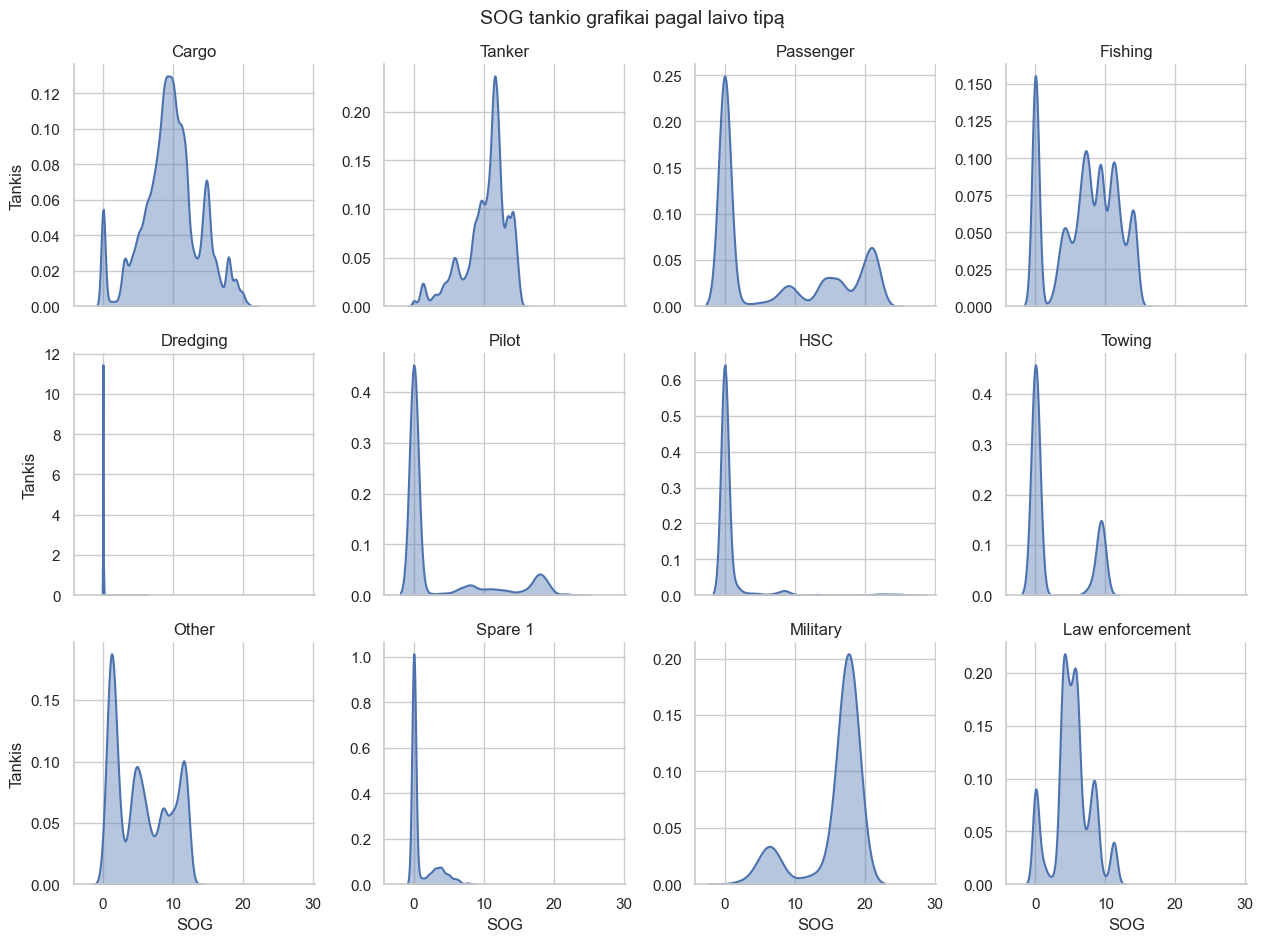

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

dfp = df_filtered.dropna(subset=["Ship type", "SOG"]).copy()
dfp["Ship type"] = dfp["Ship type"].astype(str).str.strip()

sns.set_theme(style="whitegrid")

g = sns.FacetGrid(
    dfp,
    col="Ship type",
    col_wrap=4,
    height=3.2,
    sharex=True,   # kiekvienas turi savo X mastelį
    sharey=False    # kiekvienas turi savo Y mastelį
)

g.map_dataframe(
    sns.kdeplot,
    x="SOG",
    fill=True,
    alpha=0.4,
    linewidth=1.5
)

g.set_titles("{col_name}")
g.set_axis_labels("SOG", "Tankis")

plt.subplots_adjust(top=0.90)
g.fig.suptitle("SOG tankio grafikai pagal laivo tipą", fontsize=14)

plt.tight_layout()
plt.show()

# tankio grafikus pakeisti i staciakampe / violin grafika - sudeti viska i viena ir isskirti spalvom
padaryt visiem kintamiesiem

### pagal ROT

/Users/vilte/Desktop/6 sem/vizualizavimas/1 Lab/Laboratorinis/venv/lib/python3.13/site-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/vilte/Desktop/6 sem/vizualizavimas/1 Lab/Laboratorinis/venv/lib/python3.13/site-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/vilte/Desktop/6 sem/vizualizavimas/1 Lab/Laboratorinis/venv/lib/python3.13/site-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/vilte/Desktop/6 sem/vizualizavimas/1 Lab/Laboratorinis/venv/lib/python3.13/site-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pa

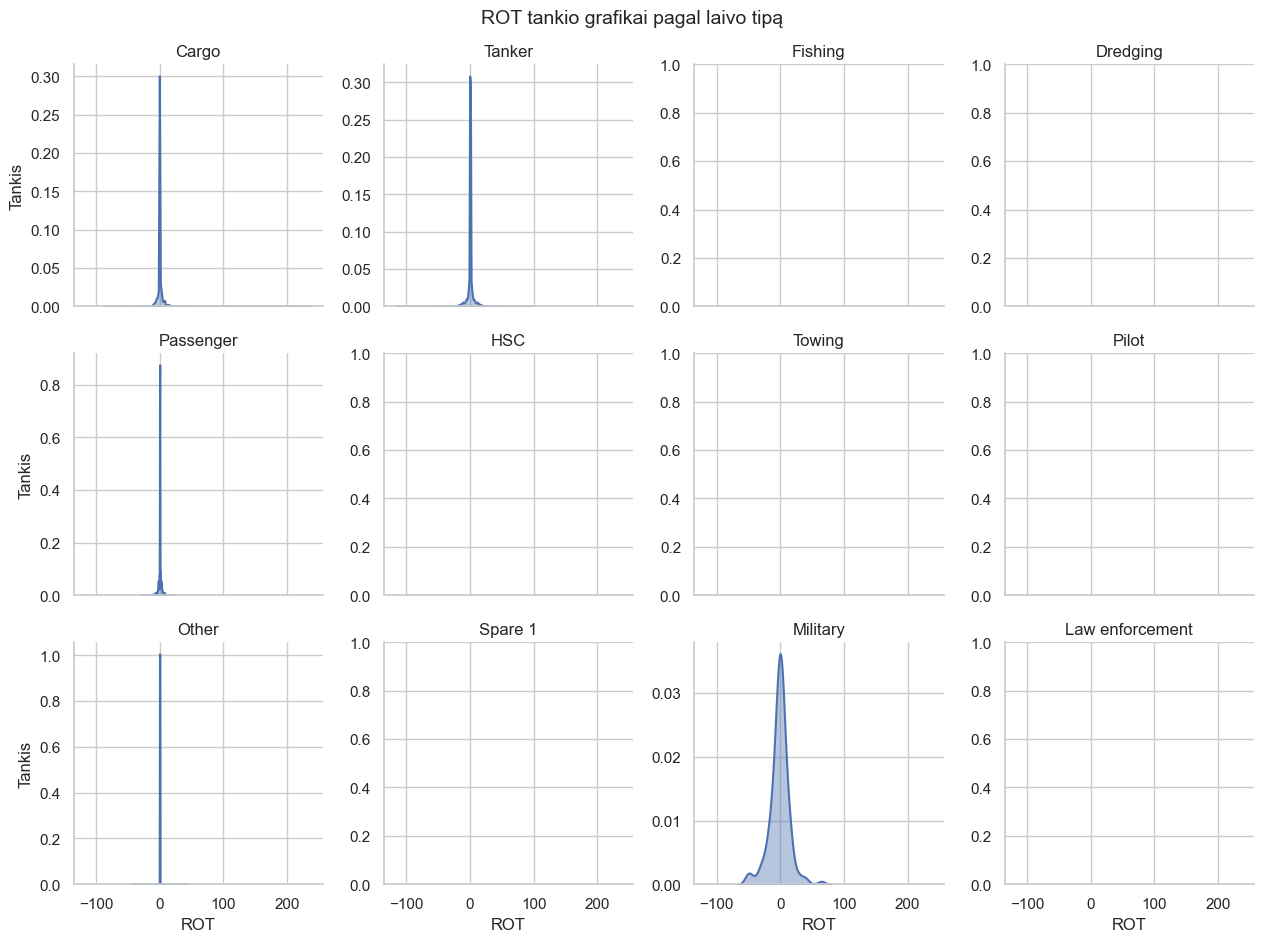

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

dfp = df_filtered.dropna(subset=["Ship type", "ROT"]).copy()
dfp["Ship type"] = dfp["Ship type"].astype(str).str.strip()

sns.set_theme(style="whitegrid")

g = sns.FacetGrid(
    dfp,
    col="Ship type",
    col_wrap=4,
    height=3.2,
    sharex=True,   # kiekvienas turi savo X mastelį
    sharey=False    # kiekvienas turi savo Y mastelį
)

g.map_dataframe(
    sns.kdeplot,
    x="ROT",
    fill=True,
    alpha=0.4,
    linewidth=1.5
)

g.set_titles("{col_name}")
g.set_axis_labels("ROT", "Tankis")

plt.subplots_adjust(top=0.90)
g.fig.suptitle("ROT tankio grafikai pagal laivo tipą", fontsize=14)

plt.tight_layout()
plt.show()

### pagal COG

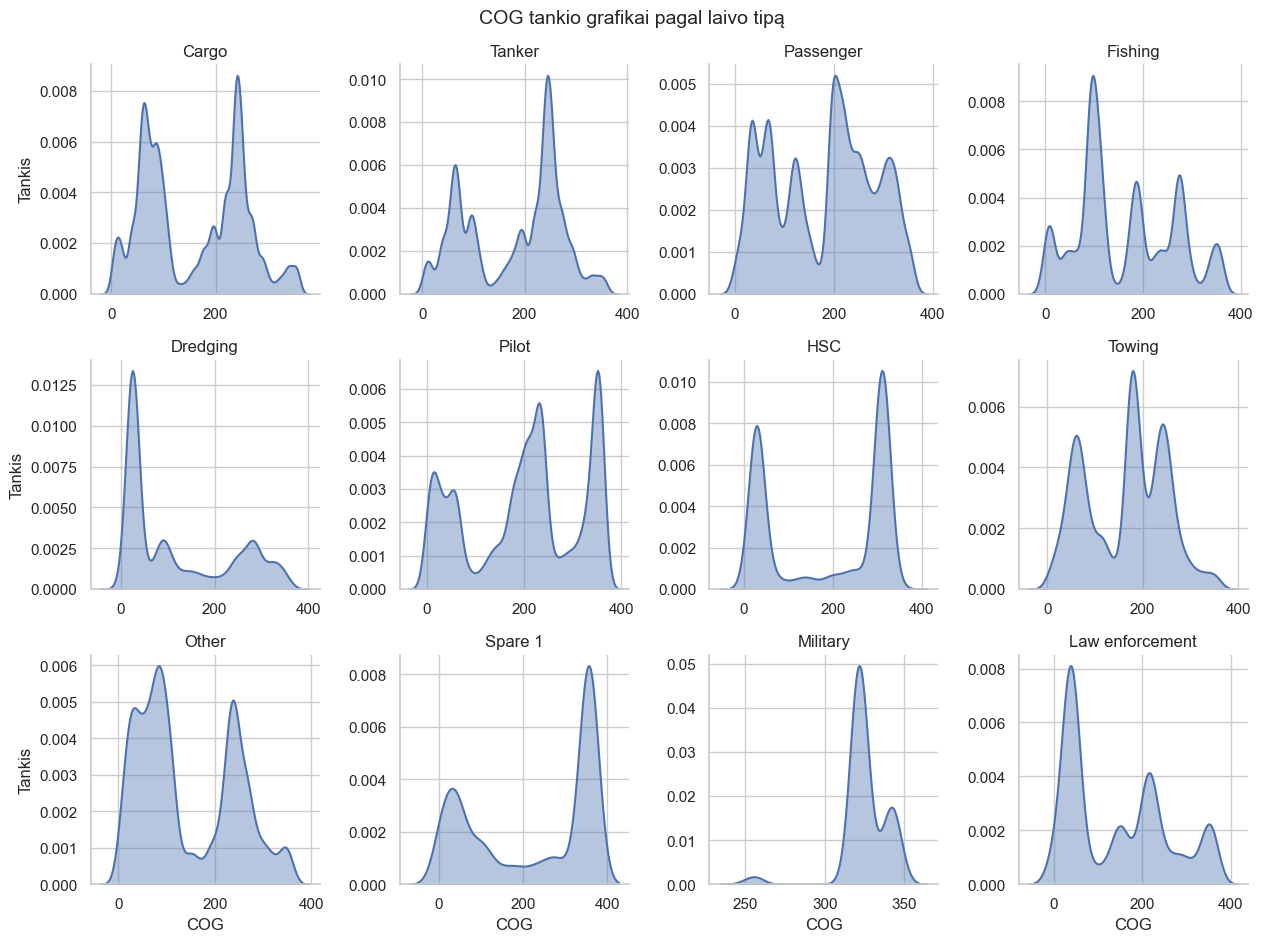

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

dfp = df_filtered.dropna(subset=["Ship type", "COG"]).copy()
dfp["Ship type"] = dfp["Ship type"].astype(str).str.strip()

sns.set_theme(style="whitegrid")

g = sns.FacetGrid(
    dfp,
    col="Ship type",
    col_wrap=4,
    height=3.2,
    sharex=False,   # kiekvienas turi savo X mastelį
    sharey=False    # kiekvienas turi savo Y mastelį
)

g.map_dataframe(
    sns.kdeplot,
    x="COG",
    fill=True,
    alpha=0.4,
    linewidth=1.5
)

g.set_titles("{col_name}")
g.set_axis_labels("COG", "Tankis")

plt.subplots_adjust(top=0.90)
g.fig.suptitle("COG tankio grafikai pagal laivo tipą", fontsize=14)

plt.tight_layout()
plt.show()